## Text classification on LeMonde2003 Dataset

In this notebook, we 
apply classification algorithms to newspaper articles published in 2003 in *Le Monde*. 

The data are in data/LeMonde2003_9classes.csv.gz

These articles concern different subjects but we will consider only articles related to the following subjects : entreprises (ENT), international (INT), arts (ART), société (SOC), France (FRA), sports (SPO), livres (LIV), télévision (TEL) and the font page articles (UNE).


> * Load the CSV file `data/LeMonde2003_9classes.csv` containing the articles using pandas [pd.read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html). How many articles do you have ? 
> * Plot the frequency histogram of the categories using seaborn [countplot](https://seaborn.pydata.org/tutorial/categorical.html) : `sns.countplot(data=df,y='category')`
> * Display the text of some of the article with the corresponding class using pandas [indexing](https://pandas.pydata.org/pandas-docs/version/0.17.0/indexing.html#indexing-integer)
> * Using the [WordCloud library](https://amueller.github.io/word_cloud/index.html), display a word cloud for the most frequent classes. You can remove the stop words using the `stopwords` option, using the list of stop words in French in `data/stop_word_fr.txt`.



In [8]:
import logging
logging.basicConfig(level=logging.CRITICAL)

In [9]:
import pandas as pd
import numpy as np
# load dataframe from CSV file
df = pd.read_csv('data/LeMonde2003_raw.csv')

In [10]:
df.index

RangeIndex(start=0, stop=3437, step=1)

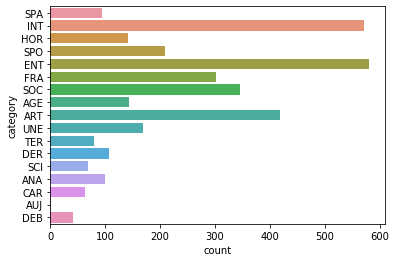

In [11]:
import seaborn as sns
%matplotlib inline

# Plot the statistics of category
sns.countplot(data=df,y='category')

In [12]:
# Print examples of the articles
df.head()

text category
0  EN DÉCIDANT de céder aux enchères la participa...      SPA
1  UNE GRAVE VIOLATION du cessez-le-feu par l'arm...      INT
2  Les documents cités sont accessibles à l'adres...      HOR
3  POUR BEAUCOUP, le rallye tient en lui l'un des...      SPO
4  Interrogé sur France 3 à propos de l'invitatio...      INT

Top 5 classes : 
   category    c
0      ENT  581
1      INT  572
2      ART  419
3      SOC  345
4      FRA  302


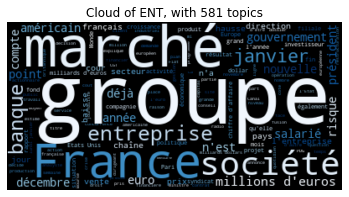

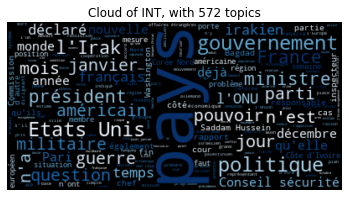

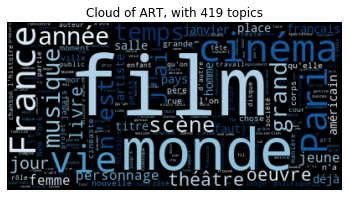

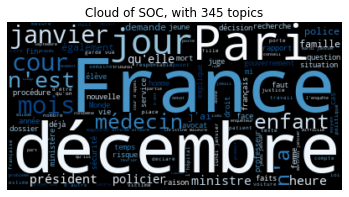

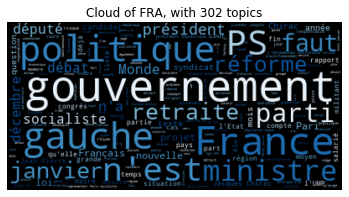

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Display one wordcloud for each of the most frequent classes

# Find the top5 most frequent classes 
k = 5
topk = df.groupby(['category'],as_index=False)['category'].agg(
    {'c':'count'}).sort_values(by=['c'], ascending=False)[0:k].reset_index(drop=True)
print('Top 5 classes : \n', topk)

# WordCloud
stopwords = set(np.loadtxt('data/stop_word_fr.txt', dtype=np.str, encoding='UTF8'))
for i in range(k):
    class_name = topk['category'][i]
    seq = ' '.join(list(df[df['category']==class_name]['text'].values)) # Combine all sentences
    wc = WordCloud(stopwords=stopwords, colormap='Blues')
    wc.generate_from_text(seq)
    plt.imshow(wc, interpolation="bilinear")
    plt.title('Cloud of %s, with %3d topics'%(class_name,topk['c'][i]))
    plt.axis("off"); plt.show()

## Bag-of-word representation

In order to apply machine learning algorithms to text, documents must be transformed into vectors. The most simple and standard way to transform a document into a vector is the *bag-of-word* encoding.

The idea is very simple : 

1. define the set of all the possible words that can appear in a document; denote its size by `max_features`.
2. for each document,  encode it with a vector of size `max_features`, with the value of the ith component of the vector equal to the number of time the ith word appears in the document.

See [the wikipedia article on Bag-of-word](https://en.wikipedia.org/wiki/Bag-of-words_model) for an example.

Scikit-learn proposes different methods to encode text into vectors : [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and [TfidfTransformer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

The encoder must first be trained on the train set and applied to the different sets, for example with the 1000  words : 

	from sklearn.feature_extraction.text import CountVectorizer
	vectorizer = CountVectorizer(max_features=1000)
    vectorizer.fit(X_train)
    X_train_counts = vectorizer.transform(X_train)
    X_test_counts = vectorizer.transform(X_test)
        
**Question**:

> * Split the dataset LeMonde2003 into train set (60%), dev set (20%)  and test set (20%) using scikit-learn [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
> * For each set, transform the text of the articles into vectors using the `CountVectorizer`, considering the 2000 most frequent words. 
> * train a naive bayes classifier on the data. Evaluate the classification accuracy on the train, dev and test sets.

> ***Important*** : the test set must not be used during the training phase, and learning the vector representation of the words is part of the training. The dev set should be an evaluation of the test set.



In [14]:
from sklearn.model_selection import train_test_split
# Split the dataset, create X (features) and y (target), print the size
X, y = df['text'].values, df['category'].values
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_, y_, test_size=0.25, random_state=0)
print('Total size X : %4d | y : %4d'%(len(X), len(y)))
print('Train size X : %4d | y : %4d'%(len(X_train), len(y_train)))
print('Valid size X : %4d | y : %4d'%(len(X_dev), len(y_dev)))
print('Test  size X : %4d | y : %4d'%(len(X_test), len(y_test)))

# Pay attention to data leaking : 
# Having test data in train set, sometimes because of the multi hierarchical split.

Total size X : 3437 | y : 3437
Train size X : 2061 | y : 2061
Valid size X :  688 | y :  688
Test  size X :  688 | y :  688


In [15]:
from sklearn.feature_extraction.text import CountVectorizer
# Create document vectors
vectorizer = CountVectorizer(max_features=2000)
vectorizer.fit(X_train)
X_train_counts = vectorizer.transform(X_train)
X_dev_counts = vectorizer.transform(X_dev)
X_test_counts = vectorizer.transform(X_test)

In [16]:
# train a Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB
print("Naive Bayes classifier using CountVectorizer\n")
for settype, X_pred, y_gt in zip(['DEV ', 'TEST'], [X_dev_counts, X_test_counts], [y_dev, y_test]):
    clf = GaussianNB()
    clf = clf.fit(X_train_counts.toarray(), y_train)
    y_pred = clf.predict(X_pred.toarray())
    print("%s Predictions : %3d \n%s Accuracy    : %.2f" % 
          (settype, y_pred.shape[0], settype, (y_pred == y_gt).sum()/y_pred.shape[0]))


Naive Bayes classifier using CountVectorizer

DEV  Predictions : 688 
DEV  Accuracy    : 0.44
TEST Predictions : 688 
TEST Accuracy    : 0.44


## TF-IDF representation

The `CountVectorizer` encodes the text using the raw frequencies of the words. However, words that are very frequent and appear in all the documents will have a strong weight whereas they are not discriminative. The *Term-Frequency Inverse-Document-Frequency* weighting scheme take into accound the number of documents in which a given word occurs. A word that appear in many document will have less weight. See [the wikipedia page](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) for more details.

With scikit-learn, the `TfidfTransformer` is applied after the `CountVectorizer` :

	from sklearn.feature_extraction.text import TfidfTransformer
	tf_transformer = TfidfTransformer().fit(X_train_counts)
 	X_train_tf = tf_transformer.transform(X_train_counts)
	X_test_tf = tf_transformer.transform(X_test_counts)
	
**Question**:

> * Use the TF-IDF representation to train a Multinomial Naive Bayes classifier. Report your best test error rate and the error rates for all the configurations tested.

In [17]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer().fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_test_tf = tf_transformer.transform(X_test_counts)

In [18]:
# Train a Multinomial Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB
records = []
print("Multinomial Naive Bayes classifier using TF-IDF\n")
for fit_prior in [True, False]:
    for a in range(10): # smoothing 
        alpha = a/10+.1
        clf = MultinomialNB(alpha=alpha, class_prior=None, fit_prior=fit_prior) 
        clf = clf.fit(X_train_counts.toarray(), y_train)
        y_pred = clf.predict(X_test_counts.toarray())
        acc = (y_pred == y_test).sum()/y_pred.shape[0]
        records.append([alpha, fit_prior, acc])
        
records = pd.DataFrame(records, columns=['alpha', 'fit_prior', 'accuracy'])
print('Best test accuracy :\n', records[records['accuracy']==records['accuracy'].max()], '\n')
print('Experiment records :\n', records)

Multinomial Naive Bayes classifier using TF-IDF

Best test accuracy :
    alpha  fit_prior  accuracy
2    0.3       True  0.635174 

Experiment records :
     alpha  fit_prior  accuracy
0     0.1       True  0.629360
1     0.2       True  0.632267
2     0.3       True  0.635174
3     0.4       True  0.633721
4     0.5       True  0.632267
5     0.6       True  0.626453
6     0.7       True  0.625000
7     0.8       True  0.625000
8     0.9       True  0.620640
9     1.0       True  0.619186
10    0.1      False  0.630814
11    0.2      False  0.630814
12    0.3      False  0.629360
13    0.4      False  0.623547
14    0.5      False  0.619186
15    0.6      False  0.620640
16    0.7      False  0.619186
17    0.8      False  0.616279
18    0.9      False  0.613372
19    1.0      False  0.616279


## Error analysis

The classification error rate give an evaluation of the performance for all the classes. But since the classes are not equally distributed, they may not be equally well modelized. In order to get a better idea of the performance of the classifier, detailed metrics must be used : 

* [metrics.classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) provides a detailed analysis per class : the precision (amongst all the example classified as class X, how many are really from the classX) and the recall (amongst all the example that are from the class X, how many are classified as class X) and the F-Score which is as a weighted harmonic mean of the precision and recall.
* [metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) which give the confusions between the classes. It can be displayed in color with [plot_confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html#sklearn.metrics.plot_confusion_matrix).

**Question**:

> * Report the `classification_report` for your  classifier. Which classes have the best scores ? Why ?
> * Report the `confusion_matrix` for your  classifier. Which classes are the most confused ? Why ?


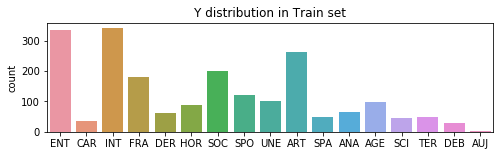

Classification report : 
               precision    recall  f1-score   support

         AGE       0.77      0.74      0.76        23
         ANA       0.06      0.05      0.05        21
         ART       0.61      0.83      0.71        72
         CAR       0.60      0.71      0.65        17
         DEB       0.05      0.33      0.09         3
         DER       0.67      0.24      0.35        17
         ENT       0.76      0.73      0.75       127
         FRA       0.62      0.63      0.62        62
         HOR       0.46      0.25      0.32        24
         INT       0.69      0.69      0.69       110
         SCI       0.33      0.88      0.48         8
         SOC       0.58      0.72      0.64        78
         SPA       0.75      0.11      0.19        27
         SPO       0.89      0.85      0.87        46
         TER       0.35      0.50      0.41        18
         UNE       0.14      0.03      0.05        35

    accuracy                           0.62       688


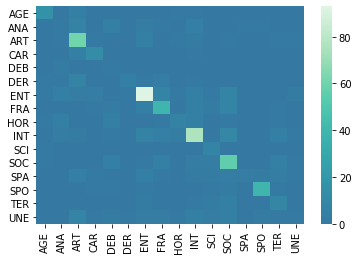

In [19]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
plt.figure(figsize=[8, 2])
sns.countplot(y_train); plt.title('Y distribution in Train set'); plt.show()
print('Classification report : \n', classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), center=1, cmap='mako',
            xticklabels=np.unique(y_pred), yticklabels=np.unique(y_pred))

## Hyperparameter optimization

The classification process has many parameters : alpha for the classifier, max_features, max_df, min_df, using idf or not, ngram orders for the Count of TfIDF transformer. These parameters can be optimized by a grid search using GridSearchCV.

**Question**:

> * Using the template code below, find the best values for the parameter alpha,  max_features, max_df, min_df, use_idf, ngram_range


In [20]:
# Hyperameters optimization with GridSearchCV = parallel processing
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from pprint import pprint
from time import time
import logging
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

parameters = {'vect__max_df': [1.0], 
              'vect__min_df': [0.5],
              'vect__max_features': [100, 1000],
              'vect__ngram_range': [(1, 1), (2, 2)],
              'tfidf__use_idf': [True, False],
              'clf__alpha': [0.5, 0.75, 1.0]}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected block
    # find the best parameters for both the feature extraction and the classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=1, verbose=2)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train[:1000], y_train[:1000])
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': [0.5, 0.75, 1.0],
 'tfidf__use_idf': [True, False],
 'vect__max_df': [1.0],
 'vect__max_features': [100, 1000],
 'vect__min_df': [0.5],
 'vect__ngram_range': [(1, 1), (2, 2)]}
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] clf__alpha=0.5, tfidf__use_idf=True, vect__max_df=1.0, vect__max_features=100, vect__min_df=0.5, vect__ngram_range=(1, 1) 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__alpha=0.5, tfidf__use_idf=True, vect__max_df=1.0, vect__max_features=100, vect__min_df=0.5, vect__ngram_range=(1, 1), total=   0.3s
[CV] clf__alpha=0.5, tfidf__use_idf=True, vect__max_df=1.0, vect__max_features=100, vect__min_df=0.5, vect__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  clf__alpha=0.5, tfidf__use_idf=True, vect__max_df=1.0, vect__max_features=100, vect__min_df=0.5, vect__ngram_range=(1, 1), total=   0.3s
[CV] clf__alpha=0.5, tfidf__use_idf=True, vect__max_df=1.0, vect__max_features=100, vect__min_df=0.5, vect__ngram_range=(1, 1) 
[CV]  clf__alpha=0.5, tfidf__use_idf=True, vect__max_df=1.0, vect__max_features=100, vect__min_df=0.5, vect__ngram_range=(1, 1), total=   0.3s
[CV] clf__alpha=0.5, tfidf__use_idf=True, vect__max_df=1.0, vect__max_features=100, vect__min_df=0.5, vect__ngram_range=(2, 2) 
[CV]  clf__alpha=0.5, tfidf__use_idf=True, vect__max_df=1.0, vect__max_features=100, vect__min_df=0.5, vect__ngram_range=(2, 2), total=   0.7s
[CV] clf__alpha=0.5, tfidf__use_idf=True, vect__max_df=1.0, vect__max_features=100, vect__min_df=0.5, vect__ngram_range=(2, 2) 
[CV]  clf__alpha=0.5, tfidf__use_idf=True, vect__max_df=1.0, vect__max_features=100, vect__min_df=0.5, vect__ngram_range=(2, 2), total=   0.7s
[CV] clf__alpha=0.5, tfidf__use_idf=True, ve

[CV]  clf__alpha=0.75, tfidf__use_idf=True, vect__max_df=1.0, vect__max_features=1000, vect__min_df=0.5, vect__ngram_range=(1, 1), total=   0.4s
[CV] clf__alpha=0.75, tfidf__use_idf=True, vect__max_df=1.0, vect__max_features=1000, vect__min_df=0.5, vect__ngram_range=(1, 1) 
[CV]  clf__alpha=0.75, tfidf__use_idf=True, vect__max_df=1.0, vect__max_features=1000, vect__min_df=0.5, vect__ngram_range=(1, 1), total=   0.3s
[CV] clf__alpha=0.75, tfidf__use_idf=True, vect__max_df=1.0, vect__max_features=1000, vect__min_df=0.5, vect__ngram_range=(2, 2) 
[CV]  clf__alpha=0.75, tfidf__use_idf=True, vect__max_df=1.0, vect__max_features=1000, vect__min_df=0.5, vect__ngram_range=(2, 2), total=   0.7s
[CV] clf__alpha=0.75, tfidf__use_idf=True, vect__max_df=1.0, vect__max_features=1000, vect__min_df=0.5, vect__ngram_range=(2, 2) 
[CV]  clf__alpha=0.75, tfidf__use_idf=True, vect__max_df=1.0, vect__max_features=1000, vect__min_df=0.5, vect__ngram_range=(2, 2), total=   0.7s
[CV] clf__alpha=0.75, tfidf__u

[CV]  clf__alpha=1.0, tfidf__use_idf=False, vect__max_df=1.0, vect__max_features=100, vect__min_df=0.5, vect__ngram_range=(1, 1), total=   0.3s
[CV] clf__alpha=1.0, tfidf__use_idf=False, vect__max_df=1.0, vect__max_features=100, vect__min_df=0.5, vect__ngram_range=(1, 1) 
[CV]  clf__alpha=1.0, tfidf__use_idf=False, vect__max_df=1.0, vect__max_features=100, vect__min_df=0.5, vect__ngram_range=(1, 1), total=   0.3s
[CV] clf__alpha=1.0, tfidf__use_idf=False, vect__max_df=1.0, vect__max_features=100, vect__min_df=0.5, vect__ngram_range=(2, 2) 
[CV]  clf__alpha=1.0, tfidf__use_idf=False, vect__max_df=1.0, vect__max_features=100, vect__min_df=0.5, vect__ngram_range=(2, 2), total=   0.7s
[CV] clf__alpha=1.0, tfidf__use_idf=False, vect__max_df=1.0, vect__max_features=100, vect__min_df=0.5, vect__ngram_range=(2, 2) 
[CV]  clf__alpha=1.0, tfidf__use_idf=False, vect__max_df=1.0, vect__max_features=100, vect__min_df=0.5, vect__ngram_range=(2, 2), total=   0.7s
[CV] clf__alpha=1.0, tfidf__use_idf=F

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   37.7s finished


done in 38.169s

Best score: 0.204
Best parameters set:
	clf__alpha: 0.5
	tfidf__use_idf: True
	vect__max_df: 1.0
	vect__max_features: 100
	vect__min_df: 0.5
	vect__ngram_range: (1, 1)


In [21]:
# Best parameters
print(grid_search.best_score_)
print('Best Params:\n', grid_search.best_params_)

0.204
Best Params:
 {'clf__alpha': 0.5, 'tfidf__use_idf': True, 'vect__max_df': 1.0, 'vect__max_features': 100, 'vect__min_df': 0.5, 'vect__ngram_range': (1, 1)}


## Classification with Neural networks

Neural networks can be trained to learn both the vector representation of the words (instead of tf-idf) and how to classify the documents. The code below allows you to train a neural text classifier using word embeddings using Keras. Most of the code is written, you only have to define the architecture of the network with the correct parameters before training it : 

**Question**:

> * Define a neural network in the function `get_model()` with the following parameters : 
>  * use only the 10 000 most frequent words in the documents
>  * use 1024 as the maximal number of words in the articles
>  * use an embedding size of 300:  [embedding layer](https://keras.io/layers/embeddings/)
>  * use a dropout of 0.5:  [dropout layer](https://keras.io/layers/core/#dropout)
>  * use 32 convolutional filters of size 2 x EMBED_SIZE: [1D convolutional layer](https://keras.io/layers/convolutional/#conv1d)
>  * use a max pooling of size 2 : [1D Max Pooling](https://keras.io/layers/pooling/#maxpooling1d)
> * Train the model and compare its accuracy to the Naive Bayes models.



In [22]:
import ast
import os
from nn_utils import TrainingHistory
from keras.layers import Dense, Embedding, Input
from keras.layers import GRU, Dropout, MaxPooling1D, Conv1D, Flatten
from keras.models import Model
import numpy as np
import itertools
from keras.utils import np_utils
from sklearn.metrics import (classification_report, 
                             precision_recall_fscore_support, 
                             accuracy_score)

from keras.preprocessing import text, sequence



Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [23]:
# Model parameters
MAX_FEATURES = 10000 # Hyper_param
MAX_TEXT_LENGTH = 1024 # Hyper_param
EMBED_SIZE  = 300 # Hyper_param
BATCH_SIZE = 16
EPOCHS = 10
VALIDATION_SPLIT = 0.1

In [24]:
def get_train_test(train_raw_text, test_raw_text):
    
    tokenizer = text.Tokenizer(num_words=MAX_FEATURES)

    tokenizer.fit_on_texts(list(train_raw_text))
    train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
    test_tokenized = tokenizer.texts_to_sequences(test_raw_text)
    return sequence.pad_sequences(train_tokenized, maxlen=MAX_TEXT_LENGTH), \
           sequence.pad_sequences(test_tokenized, maxlen=MAX_TEXT_LENGTH)



def get_model():

    inp = Input(shape=(MAX_TEXT_LENGTH,))
    model = Embedding(MAX_FEATURES, EMBED_SIZE)(inp)
    model = Dropout(0.5)(model)
    model = Conv1D(filters=32, kernel_size=100, padding='same', activation='relu')(model)
    model = MaxPooling1D(pool_size=2)(model)
    model = Flatten()(model)
    model = Dense(17, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model


def train_fit_predict(model, x_train, x_test, y, history):
    
    model.fit(x_train, y,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS, verbose=1,
              validation_split=VALIDATION_SPLIT)

    return model.predict(x_test)


# Get the list of different classes
CLASSES_LIST = np.unique(y_train)
n_out = len(CLASSES_LIST)
print(CLASSES_LIST)

# Convert clas string to index
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(CLASSES_LIST)
y_train = le.transform(y_train) 
y_test = le.transform(y_test) 
train_y_cat = np_utils.to_categorical(y_train, n_out)

# get the textual data in the correct format for NN
x_vec_train, x_vec_test = get_train_test(X_train, X_test)
print(len(x_vec_train), len(x_vec_test))

# define the NN topology
model = get_model()

# Define training procedure
history = TrainingHistory(x_vec_test, y_test, CLASSES_LIST)

# Train and predict
y_predicted = train_fit_predict(model, x_vec_train, x_vec_test, train_y_cat, history).argmax(1)


print("Test Accuracy:", accuracy_score(y_test, y_predicted))

p, r, f1, s = precision_recall_fscore_support(y_test, y_predicted, 
                                              average='micro',
                                              labels=[x for x in 
                                                      np.unique(y_train) 
                                                      if x not in ['CSDECMOTV']])

print('p r f1 %.1f %.2f %.3f' % (np.average(p, weights=s)*100.0, 
                                 np.average(r, weights=s)*100.0, 
                                 np.average(f1, weights=s)*100.0))


print(classification_report(y_test, y_predicted, labels=[x for x in 
                                                       np.unique(y_train) 
                                                       if x not in ['CSDECMOTV']]))

['AGE' 'ANA' 'ART' 'AUJ' 'CAR' 'DEB' 'DER' 'ENT' 'FRA' 'HOR' 'INT' 'SCI'
 'SOC' 'SPA' 'SPO' 'TER' 'UNE']
2061 688
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1024, 300)         3000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024, 300)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1024, 32)          960032    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 512, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
___________

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


<font color=brick> Comments:

<font color=midnightblue> Only with 10 epoches of training, the accuary is higher than the Multinomial Naive Bayes classifier using TF-IDF:
    
 Accuracy of Multinomial Naive Bayes classifier:
 
    0.204
 
CNN trianed for 10 epoches: 

    0.536